In [1]:
%config IPCompleter.greedy=True

In [2]:
from dask.distributed import Client
#client = Client('dcache-dot1.desy.de:8001')
client = Client()
client
client.restart()

Client Scheduler: tcp://127.0.0.1:45563 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 12 Memory: 50.42 GB


In [3]:
import numpy as np
import dask.array as da
X_train = np.load("/nfs/dust/atlas/user/hteagle/PyAnalysisUtils/ML/NN/data/processed/xgboost-Wh_nominal_reco/X_train.npy")
Y_train = np.load("/nfs/dust/atlas/user/hteagle/PyAnalysisUtils/ML/NN/data/processed/xgboost-Wh_nominal_reco/Y_train.npy")
X_train = da.from_array(X_train, chunks=50000)
Y_train = da.from_array(Y_train, chunks=50000)
X_test = np.load("/nfs/dust/atlas/user/hteagle/PyAnalysisUtils/ML/NN/data/processed/xgboost-Wh_nominal_reco/X_test.npy")
Y_test = np.load("/nfs/dust/atlas/user/hteagle/PyAnalysisUtils/ML/NN/data/processed/xgboost-Wh_nominal_reco/Y_test.npy")
X_test = da.from_array(X_test, chunks=50000)
Y_test = da.from_array(Y_test, chunks=50000)

In [4]:
split_fraction = 0.8
lam = 0
alpha = 0
max_depth = 4
gamma = 0
eta = 0.99
min_child_weight = 0.0
subsample = 0.9
colsample_bytree = 0.8
xgb_early_stopping = 5
n_threads = -1
positive_scale = 1
num_class = 5
n_rounds = 200

In [5]:
param = {
    "lambda": lam,
    "alpha": alpha,
    "max_depth": max_depth,
    "gamma": gamma,
    "eta": eta,
    "objective": "multi:softprob",
    "nthread": n_threads,
    "tree_method": "hist",
    "eval_metric": ["merror", "mlogloss"],
    "subsample": subsample,
    "colsample_bytree": colsample_bytree,
    "seed": 123,
    "random_state": 123,
    "num_class":num_class
}

In [6]:
import xgboost as xgb
dtrain = xgb.dask.DaskDMatrix(client, X_train, Y_train)
dtest = xgb.dask.DaskDMatrix(client, X_test, Y_test)

In [7]:
%time output = xgb.dask.train(client, {'tree_method': 'hist'}, dtrain, num_boost_round=10,evals=[(dtrain, 'train')])
bst_xgboost = output['booster']
history = output['history']

CPU times: user 1.9 s, sys: 332 ms, total: 2.23 s
Wall time: 33.9 s


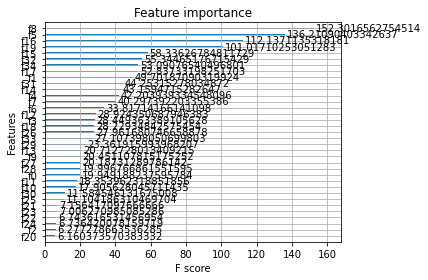

In [9]:
%matplotlib inline
import xgboost
import matplotlib.pyplot as plt
by_gain = xgboost.plot_importance(bst_xgboost, importance_type="gain")
plt.tight_layout()

In [9]:
X_test.persist()
Y_test.persist()

dask.array<array, shape=(1063628,), dtype=int64, chunksize=(50000,), chunktype=numpy.ndarray>

In [6]:
from xgboost import XGBClassifier
#from dask_xgboost import XGBClassifier
#from sklearn.model_selection import GridSearchCV
from dask_ml.model_selection import GridSearchCV
opt_clf = XGBClassifier(param)
hyparams={}
hyparams["learning_rate"] = [0.2,0.5,0.9]
hyparams["max_depth"] = [5,6,7,8]
hyparams["lambda"] = [0,0.1,0.5,1]
search = GridSearchCV(opt_clf, hyparams, scoring='f1_macro')
search

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None...
                                                'num_class': 5,
                                                'objective': 'multi:softprob',
                                                'random_state': 123,
                                                'seed': 123, 'subsample': 0.9,
      

In [7]:
%time _ = search.fit(X_train,Y_train)

CPU times: user 2min 13s, sys: 32.1 s, total: 2min 45s
Wall time: 20h 8min 53s


In [23]:
search.best_params_
search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='', lambda=1,
              learning_rate=0.5, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='approx', validate_parameters=1, verbosity=None)

Let's try some analysis with yellowbrick?

/afs/desy.de/user/h/hteagle/miniconda3/envs/dask_lab/lib/python3.6/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


0.8665247624169352

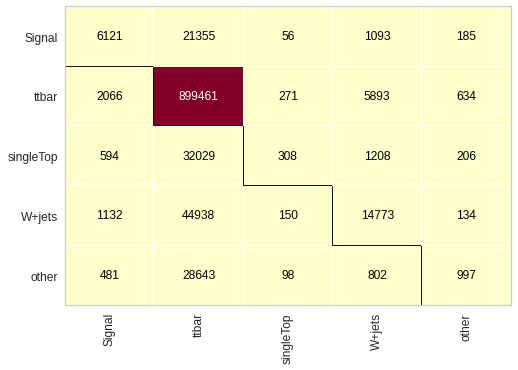

In [24]:
from yellowbrick.classifier import ConfusionMatrix
confs = ConfusionMatrix(search.best_estimator_, classes=["Signal","ttbar","singleTop","W+jets","other"], is_fitted=True)
confs.score(X_test, Y_test)

In [5]:
from yellowbrick.classifier import ROCAUC

/afs/desy.de/user/h/hteagle/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


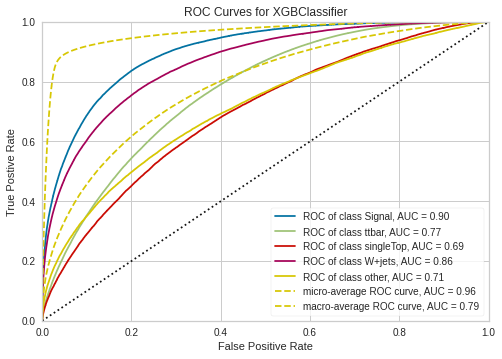

In [30]:
curves = ROCAUC(search.best_estimator_, classes=["Signal","ttbar","singleTop","W+jets","other"], is_fitted=True)
curves.score(X_test, Y_test)
curves.show()

In [4]:
from joblib import dump, load

In [34]:
dump(search.best_estimator_, "hyperam_search_14_08.joblib")

['hyperam_search_14_08.joblib']

In [36]:
clf = load("hyperam_search_14_08.joblib")

In [37]:
clf

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='', lambda=1,
              learning_rate=0.5, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='approx', validate_parameters=1, verbosity=None)

/afs/desy.de/user/h/hteagle/.local/lib/python3.6/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


NameError: name 'X_test' is not defined

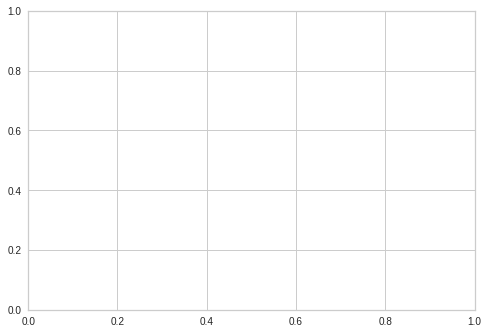

In [6]:
testcurves = ROCAUC(clf, classes=["Signal","ttbar","singleTop","W+jets","other"], is_fitted=True)
testcurves.score(X_test, Y_test)
testcurves.show()

In [7]:
import sys
sys.path.append("../")
import Driver
sys.argv = ["foo","-r","preSelection"]
Driver.parse()
import NN_driver
NN_driver.load_XGB_variables()
from dataset import bbMeT_NN
dataset = bbMeT_NN(root='data', device="cpu", transform=None)
import utils.utils as ut
to_load = ["C1N2_Wh_300.0_150.0", "C1N2_Wh_350.0_200.0", "C1N2_Wh_400.0_250.0", "C1N2_Wh_450.0_300.0"]
signal_samples = [ut.load_numpy(dataset, NN_driver, single_sample=sam, dMatrix=True) for sam in to_load]

Driver       :: INFO     ::       Setting up Driver from /nfs/dust/atlas/user/hteagle/PyAnalysisUtils/Driver.py
Driver       :: INFO     ::       NO VARIABLES SUPPLIED ON THE COMMAND LINE, JUST DRAWING ONE BIN
Driver       :: INFO     ::       Variables from the command line...
Driver       :: INFO     ::       	 {'var': '1', 'nbins': 1, 'xmin': 0.0, 'xmax': 2.0}
DatasetLoader :: INFO     ::       Attempt to load:/nfs/dust/atlas/user/hteagle/PyAnalysisUtils/ML/NN/data/processed/data_Wh_21_2_112_reco_sig.pt
DatasetLoader :: INFO     ::       Loading a single sample
Samples      :: INFO     ::       
Samples      :: INFO     ::       Looking in path=/nfs/dust/atlas/user/hteagle/Wh_samples/Wh_21.2.112/MC/
Samples      :: INFO     ::       Setup a TChain for sample=C1N2_Wh_300.0_150.0 with treename=CollectionTree_PFlow_
Samples      :: INFO     ::       Adding sample to C1N2_Wh_300.0_150.0/CollectionTree_PFlow_ with pattern=*C1N2_Wh_hbb_300p0_150p0*
Samples      :: INFO     ::       Loaded

Regions: ['preSelection']


DatasetLoader :: INFO     ::       Using scaler: /nfs/dust/atlas/user/hteagle/PyAnalysisUtils/ML/NN/data/processed/scaler_Wh_21_2_112_reco_sig.save
DatasetLoader :: INFO     ::       Loading a single sample
Samples      :: INFO     ::       
Samples      :: INFO     ::       Looking in path=/nfs/dust/atlas/user/hteagle/Wh_samples/Wh_21.2.112/MC/
Samples      :: INFO     ::       Setup a TChain for sample=C1N2_Wh_350.0_200.0 with treename=CollectionTree_PFlow_
Samples      :: INFO     ::       Adding sample to C1N2_Wh_350.0_200.0/CollectionTree_PFlow_ with pattern=*C1N2_Wh_hbb_350p0_200p0*
Samples      :: INFO     ::       Loaded chain C1N2_Wh_350.0_200.0/CollectionTree_PFlow_ with 1366 events
DatasetLoader :: INFO     ::       Using scaler: /nfs/dust/atlas/user/hteagle/PyAnalysisUtils/ML/NN/data/processed/scaler_Wh_21_2_112_reco_sig.save
DatasetLoader :: INFO     ::       Loading a single sample
Samples      :: INFO     ::       
Samples      :: INFO     ::       Looking in path=/nfs/d

Regions: ['preSelection']
Regions: ['preSelection']


DatasetLoader :: INFO     ::       Using scaler: /nfs/dust/atlas/user/hteagle/PyAnalysisUtils/ML/NN/data/processed/scaler_Wh_21_2_112_reco_sig.save
DatasetLoader :: INFO     ::       Loading a single sample
Samples      :: INFO     ::       
Samples      :: INFO     ::       Looking in path=/nfs/dust/atlas/user/hteagle/Wh_samples/Wh_21.2.112/MC/
Samples      :: INFO     ::       Setup a TChain for sample=C1N2_Wh_450.0_300.0 with treename=CollectionTree_PFlow_
Samples      :: INFO     ::       Adding sample to C1N2_Wh_450.0_300.0/CollectionTree_PFlow_ with pattern=*C1N2_Wh_hbb_450p0_300p0*
Samples      :: INFO     ::       Loaded chain C1N2_Wh_450.0_300.0/CollectionTree_PFlow_ with 997 events
DatasetLoader :: INFO     ::       Using scaler: /nfs/dust/atlas/user/hteagle/PyAnalysisUtils/ML/NN/data/processed/scaler_Wh_21_2_112_reco_sig.save


Regions: ['preSelection']


In [62]:
import importlib
importlib.reload(XGB_board)
import XGB_board
clf._Booster.feature_names= ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34']
new_board = XGB_board.board_object(clf._Booster, output_dir="current_log/")

New output:current_log/2020-08-20/13:37:50.224380


In [63]:
dtrain, dtest, X_train, X_test, Y_train, Y_test, W_train, W_test, reco_samples, truth_samples = ut.load_xgboost("Wh_nominal_reco/")

[13:37:52] 4254508x35 matrix with 148907780 entries loaded from /nfs/dust/atlas/user/hteagle/PyAnalysisUtils/ML/NN/data/processed/xgboost-Wh_nominal_reco//train.buffer
[13:37:52] 1063628x35 matrix with 37226980 entries loaded from /nfs/dust/atlas/user/hteagle/PyAnalysisUtils/ML/NN/data/processed/xgboost-Wh_nominal_reco//test.buffer


In [64]:
new_board.get_inputs(dtrain, dtest, Y_train, Y_test, W_train, W_test)

XGBoost_board :: INFO     ::       Getting input lists
1063628it [00:13, 79307.20it/s]
XGBoost_board :: INFO     ::       Finished getting test inputs
4254508it [00:53, 79446.01it/s]
XGBoost_board :: INFO     ::       Finished getting train inputs


XGB_board    :: INFO     ::       PValue background KS: 0.9998920410953067
XGB_board    :: INFO     ::       PValue signal KS: 2.6427817956943036e-16
Warning in <TROOT::Append>: Replacing existing TH1: self.test_bkg_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: self.test_sig_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: self.train_bkg_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: self.train_sig_hist (Potential memory leak).
Info in <TCanvas::Print>: png file current_log/2020-08-20/13:37:50.224380/root_hists.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_n
Info in <TH1F::Chi2TestX>: There is a bin in h1 with less than 10 effective events.

Info in <TH1F::Chi2TestX>: There is a bin in h2 with less than 10 effective events.

Info in <TCanvas::Print>: png file current_log/2020-08-20/13:37:50.224380/root_norm_hists.png has been created


Time to plot with ROOT: 0:00:49.194340


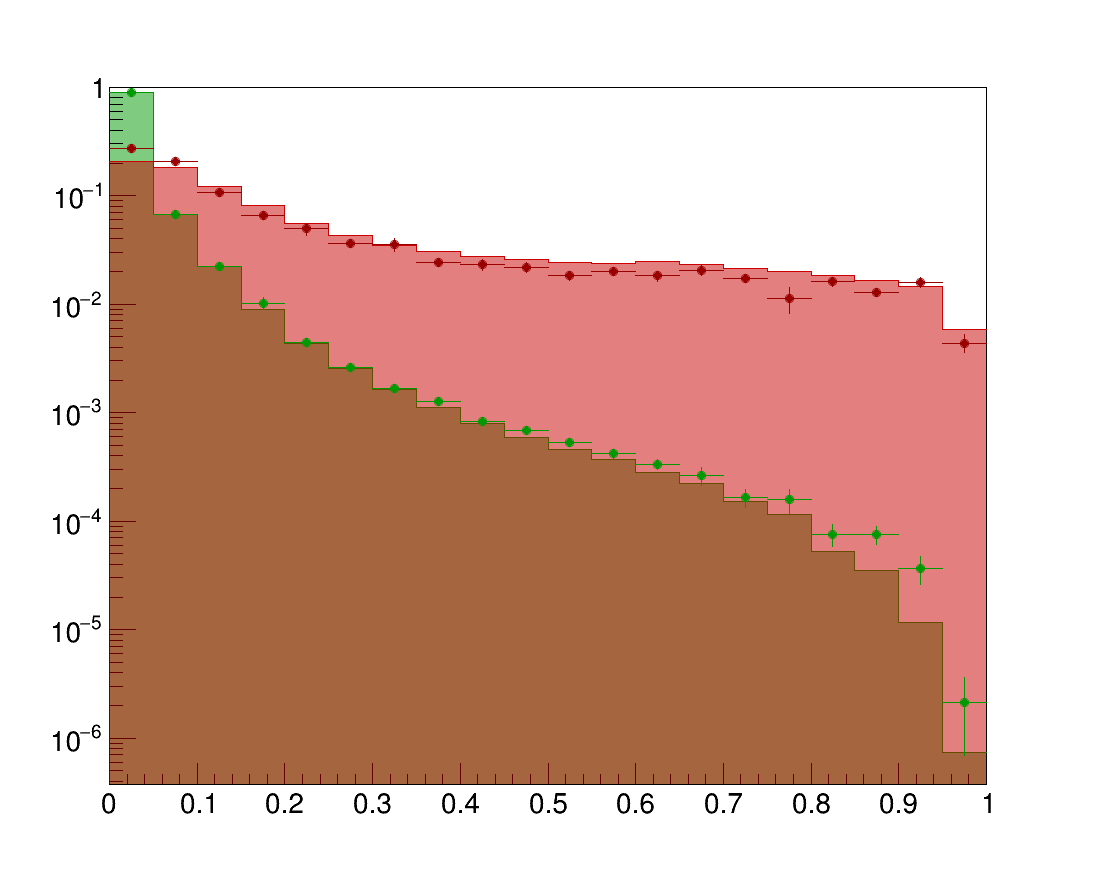

In [65]:
c = new_board.draw_train_test_root()
new_board.model.feature_names=["m_CTcorr","ETMiss","ETMissPhi","metsig_New","m_T","m_bb","m_b1l","m_b2l","amT2","pTl1","pTb1","pTb2","pTj1","pTj2","pTj3","b1_quantile","b2_quantile","j1_quantile","j2_quantile","j3_quantile","phil1","phib1","phib2","phij1","phij2","phij3","etal1","etab1","etab2","etaj1","etaj2","etaj3","dRb1b2","dRL1b1","dRL1b2",]
c.Draw()

Drawing single samples


XGB_board    :: INFO     ::       Cumulative significance (10 bins) C1N2_Wh_300.0_150.0: 0.000456
XGB_board    :: INFO     ::       Cumulative significance (10 bins) C1N2_Wh_350.0_200.0: 0.000230
XGB_board    :: INFO     ::       Cumulative significance (10 bins) C1N2_Wh_400.0_250.0: 0.000012
XGB_board    :: INFO     ::       Cumulative significance (10 bins) C1N2_Wh_450.0_300.0: 0.000007
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: self.total_bkg_hist (Potential memory leak).
Info in <TCanvas::Print>: png file current_log/2020-08-20/13:37:50.224380/root_single_hists.png has been created


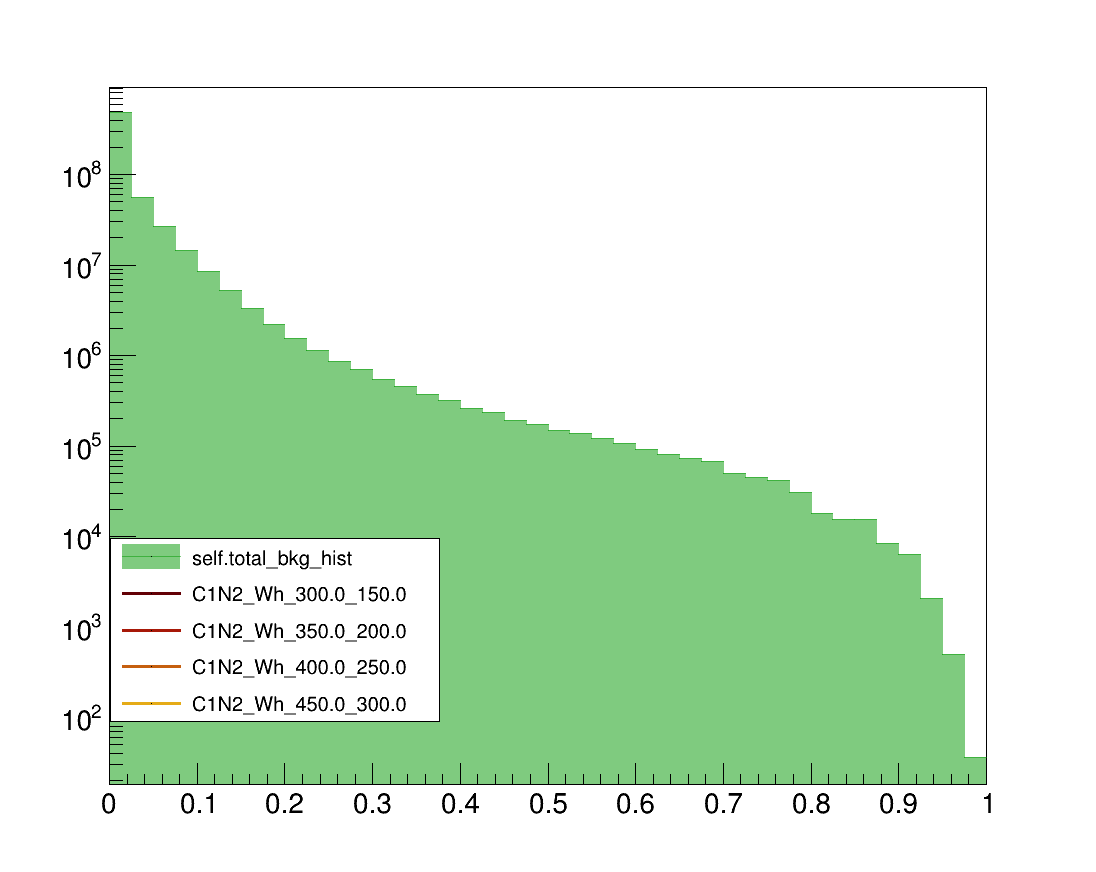

In [66]:
new_board.model_type="XGBoost"
c = new_board.draw_single_samples_root(signal_samples, to_load)
c.Draw()